<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/VAE_Imagenes_RX_Torax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders variacionales con imágenes de RX Tórax

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from google.colab import drive

In [3]:
# Leemos el conjunto RSNA del drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Rutas
train = '/content/drive/MyDrive/rsna/stage_2_train_images'
test = '/content/drive/MyDrive/rsna/stage_2_test_images'
ruta = '/content/drive/MyDrive/rsna'

In [5]:
# Cargamos el fichero con metadatos
imagenes = pd.read_csv(ruta+'/stage_2_detailed_class_info.csv')
imagenes.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [6]:
# Separamos imágenes pacientes sanos de imágenes de pacientes con anomalias
normales = imagenes[imagenes['class']=='Normal']
anormales = imagenes[imagenes['class']!='Normal']

In [7]:
#Tamaños
print(normales.shape)
print(anormales.shape)

(8851, 2)
(21376, 2)


In [8]:
#Definimos función lectura dicom
!pip install pydicom
import pydicom

     |████████████████████████████████| 1.9MB 20.3MB/s 


In [9]:
#Función lectura imagen
def leer_dicom(imagen):
  ds = pydicom.dcmread(imagen)
    
  img = ds.pixel_array
  view = ds.ViewPosition
  sexo = ds.PatientSex
  edad = ds.PatientAge
  return img, view, sexo, edad

AP
F
34


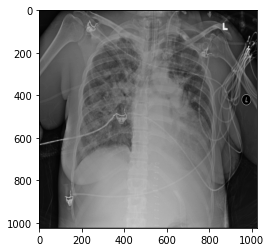

In [11]:
# Probamos lectura de la imagen
prueba ='/content/drive/MyDrive/rsna/stage_2_train_images/02099738-7465-4786-b71c-de8cdac477c3.dcm'
imagen, vista, sexo, edad = leer_dicom(prueba)
plt.imshow(imagen, cmap='gray')
print(vista)
print(sexo)
print(edad)

In [ ]:
# Creamos dataframe con datos de pacientes normales
#pacientes_normales = pd.DataFrame(columns=('id_paciente', 'vista', 'sexo', 'edad'))
#for contador in range(len(normales)):
#  _, vista, sexo, edad = leer_dicom(train + '/' + normales.iloc[contador,0] + '.dcm')
#  pacientes_normales.loc[len(pacientes_normales)]=[normales.iloc[contador,0], vista, sexo, edad]

In [12]:
#Leemos dataframe con los datos pacientes normales
pacientes_normales = pd.read_csv(ruta + '/pacientes_normales.csv')
pacientes_normales.head()

,Unnamed: 0,id_paciente,vista,sexo,edad
0,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28
1,1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63
2,2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54
3,3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48
4,4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36


In [13]:
pacientes_normales = pacientes_normales.drop(['Unnamed: 0'], axis=1)
pacientes_normales.head()

,id_paciente,vista,sexo,edad
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28
1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63
2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54
3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48
4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36


In [14]:
pacientes_normales.to_csv(ruta + '/pacientes_normales.csv')

In [15]:
# Nos quedamos con las imágenes con vista PA (Posteroanterior)
normales_PA = pacientes_normales[pacientes_normales['vista']=='PA']
normales_PA.shape

(7214, 4)

In [16]:
normales_PA['ruta']=''
for contador in range(len(normales_PA)):
  normales_PA.iloc[contador,-1] = train + '/' + normales_PA.iloc[contador,0] + '.dcm'
print(normales_PA['ruta'].head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0    /content/drive/MyDrive/rsna/stage_2_train_imag...
1    /content/drive/MyDrive/rsna/stage_2_train_imag...
2    /content/drive/MyDrive/rsna/stage_2_train_imag...
3    /content/drive/MyDrive/rsna/stage_2_train_imag...
4    /content/drive/MyDrive/rsna/stage_2_train_imag...
Name: ruta, dtype: object


In [17]:
normales_PA.head()

,id_paciente,vista,sexo,edad,ruta
0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28,/content/drive/MyDrive/rsna/stage_2_train_imag...
1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63,/content/drive/MyDrive/rsna/stage_2_train_imag...
2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54,/content/drive/MyDrive/rsna/stage_2_train_imag...
3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48,/content/drive/MyDrive/rsna/stage_2_train_imag...
4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36,/content/drive/MyDrive/rsna/stage_2_train_imag...


In [18]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda
Sat Mar  6 00:03:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [20]:
class RSNA(Dataset):
    """RSNA dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ruta_imagen = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.ruta_imagen)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.ruta_imagen.iloc[idx, 5]
        ds = pydicom.dcmread(img_name)
        image = ds.pixel_array
       
        

        if self.transform:
            image = self.transform(image)

        return image

In [21]:
normales_PA.to_csv(ruta + '/normales_PA.csv')

In [22]:
rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train)


In [23]:
rsna_dataset.ruta_imagen

,Unnamed: 0,id_paciente,vista,sexo,edad,ruta
0,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,PA,M,28,/content/drive/MyDrive/rsna/stage_2_train_imag...
1,1,009482dc-3db5-48d4-8580-5c89c4f01334,PA,M,63,/content/drive/MyDrive/rsna/stage_2_train_imag...
2,2,009eb222-eabc-4150-8121-d5a6d06b8ebf,PA,F,54,/content/drive/MyDrive/rsna/stage_2_train_imag...
3,3,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,PA,M,48,/content/drive/MyDrive/rsna/stage_2_train_imag...
4,4,00f87de5-5fe0-4921-93ea-914d7e683266,PA,M,36,/content/drive/MyDrive/rsna/stage_2_train_imag...
...,...,...,...,...,...,...
7209,8845,c1c3ec5d-20ba-42f7-91f9-48032d97ffc9,PA,F,26,/content/drive/MyDrive/rsna/stage_2_train_imag...
7210,8846,c1ca4417-83a6-43a7-a9bf-7d9587e7f14f,PA,M,33,/content/drive/MyDrive/rsna/stage_2_train_imag...
7211,8847,c1cf3255-d734-4980-bfe0-967902ad7ed9,PA,F,27,/content/drive/MyDrive/rsna/stage_2_train_imag...
7212,8849,c1edf42b-5958-47ff-a1e7-4f23d99583ba,PA,F,46,/content/drive/MyDrive/rsna/stage_2_train_imag...


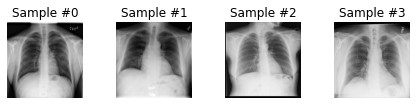

In [24]:
rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train)

fig = plt.figure()

for i in range(len(rsna_dataset)):
    sample = rsna_dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample, cmap='gray')
    
    if i == 3:
        plt.show()
        break

In [ ]:
image_size = 64
batch_size=32

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(image_size),
                                transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

trainloader = torch.utils.data.DataLoader(rsna_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [ ]:
rsna_dataset_test = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

testloader = torch.utils.data.DataLoader(rsna_dataset_test, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [25]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images)

def show_image(img):
    img = img / 2 + 0.5
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.show()

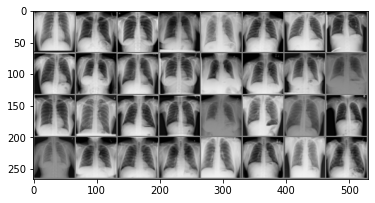

In [ ]:
trial = next(iter(trainloader))
images = trial
#print(labels)
show_images(images)

In [ ]:
trial.shape

torch.Size([32, 1, 64, 64])

# Modelo variacional base

In [ ]:

epochs = 10       # times to run the model on complete data
hidden_size = 1024       # hidden dimension
latent_size = 256         # latent vector dimension
lr = 5e-4                 # learning rate
factor_loss = 1
train_loss = []
num_imagenes = normales_PA.shape[0]

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), 1024, 1, 1)

In [ ]:
# Autoencoder convolucional variacional
class DCVAE(nn.Module):
    def __init__(self, image_channels=1, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size):
      super(DCVAE, self).__init__()

      self.encoder = nn.Sequential(
        nn.Conv2d(image_channels, 32, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 4, 2),
        nn.LeakyReLU(0.2),
        Flatten(),
    )
      self.encoder_mean = nn.Linear(hidden_size, latent_size)
      self.encoder_logvar = nn.Linear(hidden_size, latent_size)
      self.fc = nn.Linear(latent_size, hidden_size)
      self.decoder = nn.Sequential(
                                UnFlatten(),
                                nn.ConvTranspose2d(hidden_size, 128, 5, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(128, 64, 5, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(64, 32, 6, 2),
                                nn.ReLU(),
                                nn.ConvTranspose2d(32, image_channels, 6, 2),
                                nn.Sigmoid()   
                              )
  
    def sample(self, log_var, mean):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mean)
  
    def forward(self, x):
      x = self.encoder(x)
      log_var = self.encoder_logvar(x)
      mean = self.encoder_mean(x)
      z = self.sample(log_var, mean)
      x = self.fc(z)
      x = self.decoder(x)

      return x, mean, log_var

In [ ]:
from torchsummary import summary
summary(vae, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]             544
         LeakyReLU-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 14, 14]          32,832
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 6, 6]         131,200
         LeakyReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 256, 2, 2]         524,544
         LeakyReLU-8            [-1, 256, 2, 2]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                  [-1, 256]         262,400
           Linear-11                  [-1, 256]         262,400
           Linear-12                 [-1, 1024]         263,168
        UnFlatten-13           [-1, 1024, 1, 1]               0
  ConvTranspose2d-14            [-1, 12

In [ ]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [ ]:
vae.train()

for epoch in range(epochs):
  for i, images in enumerate(trainloader):
    images = images.to(device)
    optimizer.zero_grad()
    reconstructed_image, mean, log_var = vae(images)
    CE = RMSELoss(reconstructed_image, images)
    #CE = F.binary_cross_entropy(reconstructed_image, images, reduction='sum')
    # for VAE
    # CE = F.binary_cross_entropy(
    #             reconstructed_image, images.view(-1, input_size), reduction="sum"
    #         )
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    loss = factor_loss*CE + KLD
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    if(i % 100 == 0):
      print("Loss:")
      print(loss.item() / len(images))

Loss:
3.1682474613189697
Loss:
0.018675798550248146
Loss:
0.016317270696163177
Loss:
0.016123782843351364
Loss:
0.016911238431930542
Loss:
0.017869163304567337
Loss:
0.0160692036151886
Loss:
0.01450333371758461
Loss:
0.015565946698188782
Loss:
0.01449095644056797
Loss:
0.014567446894943714
Loss:
0.015370611101388931
Loss:
0.014674604870378971
Loss:
0.015699099749326706
Loss:
0.015168693847954273
Loss:
0.015153593383729458
Loss:
0.014313706196844578
Loss:
0.015303166583180428
Loss:
0.014374400489032269
Loss:
0.015315469354391098
Loss:
0.014510966837406158
Loss:
0.015741070732474327
Loss:
0.01440522912889719
Loss:
0.014997638761997223
Loss:
0.0141221322119236
Loss:
0.014640052802860737
Loss:
0.014600702561438084
Loss:
0.014368333853781223
Loss:
0.014442180283367634
Loss:
0.014756673946976662


## Autoencoder variacional mejorado

In [ ]:
image_size = 127
batch_size=128

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(image_size),
                                transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

trainloader = torch.utils.data.DataLoader(rsna_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [ ]:
rsna_dataset_test = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

testloader = torch.utils.data.DataLoader(rsna_dataset_test, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

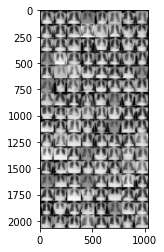

In [ ]:
trial = next(iter(trainloader))
images = trial
#print(labels)
show_images(images)

In [ ]:
epochs = 10      # times to run the model on complete data
hidden_size = 3136       # hidden dimension
latent_size = 256         # latent vector dimension
lr = 5e-4                 # learning rate
factor_loss = 10000
train_loss = []
num_imagenes = normales_PA.shape[0]

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        #print(input.shape)
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=3136):
        #print(input.shape)
        return input.view(input.size(0), 64, 7, 7)

In [ ]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [ ]:
image_size

127

In [ ]:
# Autoencoder convolucional mejorado
class DCVAE2(nn.Module):
    def __init__(self, image_channels=1, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size):
      super(DCVAE2, self).__init__()

      self.encoder = nn.Sequential(
        nn.Conv2d(image_channels, 32, 3, 2),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(32, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(64, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(64, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        Flatten(),
    )
      self.encoder_mean = nn.Linear(hidden_size, latent_size)
      self.encoder_logvar = nn.Linear(hidden_size, latent_size)
      self.fc = nn.Linear(latent_size, hidden_size)
      self.decoder = nn.Sequential(
                                UnFlatten(),
                                nn.ConvTranspose2d(64, 64, 3, 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(64, 64, 3, 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(64, 32, 3, 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(32, image_channels, 3, 2),
                                nn.Sigmoid()   
                              )
  
    def sample(self, log_var, mean):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mean)
  
    def forward(self, x):
      x = self.encoder(x)
      log_var = self.encoder_logvar(x)
      mean = self.encoder_mean(x)
      z = self.sample(log_var, mean)
      x = self.fc(z)
      
      x = self.decoder(x)
      
      return x, mean, log_var

In [ ]:
vae2 = DCVAE2().to(device)
# vae = VAE().to(device)
optimizer = optim.Adam(vae2.parameters(), lr=lr)

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(vae2, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]             320
       BatchNorm2d-2           [-1, 32, 63, 63]              64
         LeakyReLU-3           [-1, 32, 63, 63]               0
         Dropout2d-4           [-1, 32, 63, 63]               0
            Conv2d-5           [-1, 64, 31, 31]          18,496
       BatchNorm2d-6           [-1, 64, 31, 31]             128
         LeakyReLU-7           [-1, 64, 31, 31]               0
         Dropout2d-8           [-1, 64, 31, 31]               0
            Conv2d-9           [-1, 64, 15, 15]          36,928
      BatchNorm2d-10           [-1, 64, 15, 15]             128
        LeakyReLU-11           [-1, 64, 15, 15]               0
        Dropout2d-12           [-1, 64, 15, 15]               0
           Conv2d-13             [-1, 64, 7, 7]          36,928
      BatchNorm2d-14             [-1, 6

In [ ]:
vae2.train()

for epoch in range(epochs):
  for i, images in enumerate(trainloader):
    images = images.to(device)
    optimizer.zero_grad()
    reconstructed_image, mean, log_var = vae2(images)
    CE = RMSELoss(reconstructed_image, images)
    #CE = F.binary_cross_entropy(reconstructed_image, images, reduction='sum')
    # for VAE
    # CE = F.binary_cross_entropy(
    #             reconstructed_image, images.view(-1, input_size), reduction="sum"
    #         )
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    loss = factor_loss*CE + KLD
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    if(i % 100 == 0):
      print("Loss:")
      print(loss.item() / len(images))

Loss:
289.3403015136719
Loss:
159.32562255859375
Loss:
152.58572387695312
Loss:
150.6062774658203
Loss:
147.0968017578125
Loss:
144.20298767089844
Loss:
147.6514129638672
Loss:
139.23550415039062
Loss:
135.09408569335938
Loss:
137.91754150390625
Loss:
139.67860412597656
Loss:
135.53184509277344
Loss:
138.7323760986328
Loss:
132.64808654785156
Loss:
142.67105102539062
Loss:
137.16168212890625
Loss:
142.57513427734375
Loss:
143.16456604003906
Loss:
126.8063735961914
Loss:
136.9146270751953
Loss:
138.0673065185547
Loss:
129.76046752929688
Loss:
144.26373291015625
Loss:
140.40045166015625
Loss:
141.4669647216797
Loss:
124.23468780517578
Loss:
128.15853881835938
Loss:
135.52294921875
Loss:
137.4042510986328
Loss:
141.0442657470703


In [ ]:
# Cargamos modelo entrenado
vae.load_state_dict(torch.load(ruta + '/vae1.pth'))

NameError: ignored

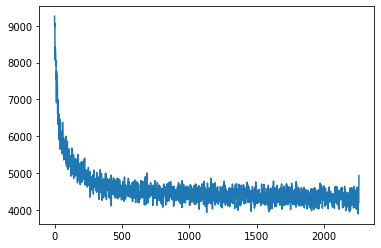

In [ ]:
plt.plot(train_loss)
plt.show()

## Generación de una imagen sintética

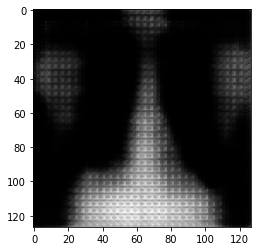

In [ ]:
start = torch.randn(1,latent_size)
with torch.no_grad():
  z = torch.FloatTensor(start)
  z = z.reshape((-1, latent_size))
  z = z.to(device)
  z = vae2.fc(z)
  generated_images = vae2.decoder(z)
  generated_images = generated_images.view(-1, image_size, image_size)
  img = generated_images[0].cpu()
  img = img / 2 + 0.5
  plt.imshow(img, cmap='gray')


## Evaluamos la reconstrucción de imágenes

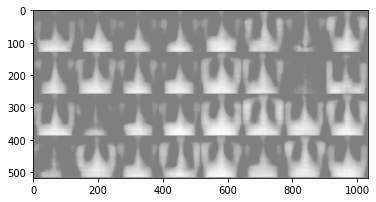

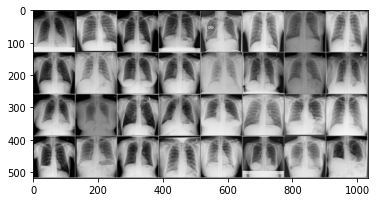

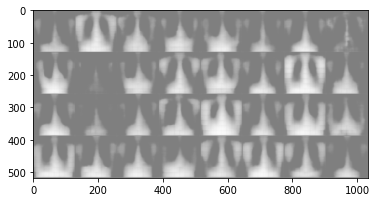

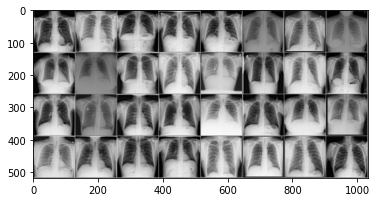

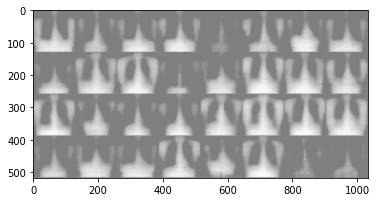

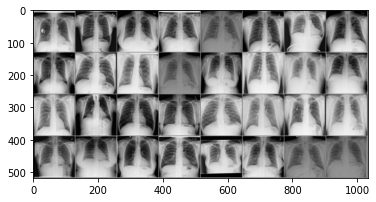

In [ ]:
vae2.eval()
vectors = []
with torch.no_grad():
  for i, images in enumerate(testloader):
    images = images.to(device)
    reconstructed_image, mean, log_var = vae2(images)
    reconstructed_image = reconstructed_image.view(-1, 1, image_size, image_size)
    temp = list(mean.tolist())
    for x in temp:
      vectors.append(x)
    if(i%100 == 0):
      show_images(reconstructed_image.cpu())
      #img_name = images_dir + "evaluation/DCVAE/" + str(i).zfill(3)
      # img_name = images_dir + "evaluation/VAE/" + str(i).zfill(3)
      #plt.savefig(img_name)
      plt.show()
      show_images(images.cpu())
      plt.show()

In [ ]:
torch.save(vae2.state_dict(), ruta + '/vae2_rmse_k10000_b128_lr5e-5.pth')

RuntimeError: ignored

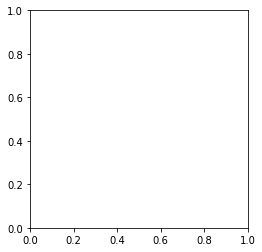

In [ ]:
show_images(reconstructed_image[4].cpu())

# Diferencia perceptual

In [ ]:
!git clone https://github.com/google-research/perceptual-quality.git

Cloning into 'perceptual-quality'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 58 (delta 26), reused 47 (delta 15), pack-reused 0
Unpacking objects: 100% (58/58), done.


In [ ]:
%cd perceptual-quality

/content/perceptual-quality


In [ ]:
!pip install -e ./

Obtaining file:///content/perceptual-quality
  Running setup.py develop for perceptual-quality


In [ ]:
import os, sys
sys.path.append(os.getcwd())

In [ ]:
from perceptual_quality import nlpd

In [ ]:
from perceptual_quality import pim

model = pim.load_trained("pim-5")

# image_A, image_B: 4D tensors, batch x height x width x 3, sRGB colorspace.
# Returns the PIM distance between A and B for each batch element.
#distance = model(image_A/255, image_B/255)

In [ ]:
%cd ..

/content


In [ ]:
image_size = 127
batch_size=32

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(image_size),
                                transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

trainloader = torch.utils.data.DataLoader(rsna_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [ ]:
rsna_dataset_test = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

testloader = torch.utils.data.DataLoader(rsna_dataset_test, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [ ]:
imgae_size = 64
pochs = 10       # times to run the model on complete data
hidden_size = 3136       # hidden dimension
latent_size = 200         # latent vector dimension
lr = 5e-4                 # learning rate
factor_loss = 10000
train_loss = []
num_imagenes = normales_PA.shape[0]

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        #print(input.shape)
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=3136):
        #print(input.shape)
        return input.view(input.size(0), 64, 7, 7)

In [ ]:
# Autoencoder convolucional mejorado
class DCVAE3(nn.Module):
    def __init__(self, image_channels=1, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size):
      super(DCVAE3, self).__init__()

      self.encoder = nn.Sequential(
        nn.Conv2d(image_channels, 32, 3, 2),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(32, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(64, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(64, 64, 3, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        Flatten(),
    )
      self.encoder_mean = nn.Linear(hidden_size, latent_size)
      self.encoder_logvar = nn.Linear(hidden_size, latent_size)
      self.fc = nn.Linear(latent_size, hidden_size)
      self.decoder = nn.Sequential(
                                UnFlatten(),
                                nn.ConvTranspose2d(64, 64, 3, 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(64, 64, 3, 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(64, 32, 3, 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(32, image_channels, 3, 2),
                                nn.Sigmoid()   
                              )
  
    def sample(self, log_var, mean):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mean)
  
    def forward(self, x):
      print('Entrada: ', x)
      x = self.encoder(x)
      log_var = self.encoder_logvar(x)
      mean = self.encoder_mean(x)
      z = self.sample(log_var, mean)
      x = self.fc(z)
      
      x = self.decoder(x)
      
      return x, mean, log_var

In [ ]:
vae3 = DCVAE3().to(device)
# vae = VAE().to(device)
optimizer = optim.Adam(vae3.parameters(), lr=lr)

In [ ]:
import tensorflow as tf
def torch_numpy(image):
  image = image.detach().cpu()
  image = image.numpy()
  image = tf.convert_to_tensor(image)
  return image

In [ ]:
vae3.train()

for epoch in range(epochs):
  for i, images in enumerate(trainloader):
    images = images.to(device)
    optimizer.zero_grad()
    reconstructed_image, mean, log_var = vae3(images)
    reconstructed_image = reconstructed_image.view(-1, image_size, image_size, 1)
    images = images.view(-1,image_size, image_size, 1)
    reconstructed_image = reconstructed_image.cpu()
    reconstructed_image = reconstructed_image.detach().numpy()
    images = images.cpu()
    images = images.detach().numpy()
    images = tf.convert_to_tensor(images)
    reconstructed_image = tf.convert_to_tensor(reconstructed_image)
    print(images)
    CE = model(reconstructed_image, images)
    #CE = nlpd.nlpd(reconstructed_image, images)

    print(CE)
    #CE = RMSELoss(reconstructed_image, images)
    #CE = F.binary_cross_entropy(reconstructed_image, images, reduction='sum')
    # for VAE
    # CE = F.binary_cross_entropy(
    #             reconstructed_image, images.view(-1, input_size), reduction="sum"
    #         )
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    loss = factor_loss*CE + KLD
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    if(i % 100 == 0):
      print("Loss:")
      print(loss.item() / len(images))

InvalidArgumentError: ignored

# Arquitectura Deep Feature Consistent Variational Autoencoder

In [94]:
image_size = 64
batch_size=128

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(image_size),
                                transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

rsna_dataset = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

trainloader = torch.utils.data.DataLoader(rsna_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [95]:
rsna_dataset_test = RSNA(csv_file=ruta + '/normales_PA.csv',
                                    root_dir=train, transform=transform)

testloader = torch.utils.data.DataLoader(rsna_dataset_test, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [75]:
image_size = 126
epochs = 10    # times to run the model on complete data
hidden_size = 9216    # hidden dimension
latent_size = 64       # latent vector dimension
lr = 5e-4                # learning rate
factor_loss = 10000
train_loss = []
num_imagenes = normales_PA.shape[0]


In [76]:
class Flatten(nn.Module):
    def forward(self, input):
        #print(input.shape)
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=hidden_size):
        #print(input.shape)
        return input.view(input.size(0), 256, 6, 6)

In [77]:
# Autoencoder convolucional mejorado
class DCVAE4(nn.Module):
    def __init__(self, image_channels=1, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size):
      super(DCVAE4, self).__init__()

      self.encoder = nn.Sequential(
        nn.Conv2d(image_channels, 32, 4, 2),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(32, 64, 4, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(64, 128, 4, 2),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        nn.Conv2d(128, 256, 4, 2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Dropout2d(p=0.25),
        Flatten(),
    )
      self.encoder_mean = nn.Linear(hidden_size, latent_size)
      self.encoder_logvar = nn.Linear(hidden_size, latent_size)
      self.fc = nn.Linear(latent_size, hidden_size)
      self.decoder = nn.Sequential(
                                UnFlatten(),
                                nn.ConvTranspose2d(256, 128, 4, 2),
                                nn.BatchNorm2d(128),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(128, 64, 4, 2),
                                nn.BatchNorm2d(64),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(64, 32, 4, 2),
                                nn.BatchNorm2d(32),
                                nn.LeakyReLU(0.2),
                                nn.Dropout2d(p=0.25),
                                nn.ConvTranspose2d(32, image_channels, 4, 2),
                                nn.Sigmoid()   
                              )
  
    def sample(self, log_var, mean):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mean)
  
    def forward(self, x):
      #print('Entrada: ', x.shape)
      x = self.encoder(x)
      #print('Encoder: ', x.shape)
      log_var = self.encoder_logvar(x)
      mean = self.encoder_mean(x)
      z = self.sample(log_var, mean)
      x = self.fc(z)
      x = self.decoder(x)
      #print('Decoder: ', x.shape)
      
      return x, mean, log_var

In [78]:
vae4 = DCVAE4().to(device)
# vae = VAE().to(device)
optimizer = optim.Adam(vae4.parameters(), lr=lr)

In [79]:
!pip install torchsummary
from torchsummary import summary
summary(vae4, input_size=(1, 126, 126))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             544
       BatchNorm2d-2           [-1, 32, 62, 62]              64
         LeakyReLU-3           [-1, 32, 62, 62]               0
         Dropout2d-4           [-1, 32, 62, 62]               0
            Conv2d-5           [-1, 64, 30, 30]          32,832
       BatchNorm2d-6           [-1, 64, 30, 30]             128
         LeakyReLU-7           [-1, 64, 30, 30]               0
         Dropout2d-8           [-1, 64, 30, 30]               0
            Conv2d-9          [-1, 128, 14, 14]         131,200
      BatchNorm2d-10          [-1, 128, 14, 14]             256
        LeakyReLU-11          [-1, 128, 14, 14]               0
        Dropout2d-12          [-1, 128, 14, 14]               0
           Conv2d-13            [-1, 256, 6, 6]         524,544
      BatchNorm2d-14            [-1, 25

In [80]:
vae4.train()

for epoch in range(epochs):
  for i, images in enumerate(trainloader):
    images = images.to(device)
    optimizer.zero_grad()
    reconstructed_image, mean, log_var = vae4(images)
    CE1 = loss_fn_alex(reconstructed_image, images).mean()
    # print(CE1)
    #CE2 = RMSELoss(reconstructed_image, images)
    # print(CE2)
    #CE = RMSELoss(reconstructed_image, images)
    #CE = F.binary_cross_entropy(reconstructed_image, images, reduction='sum')
    # for VAE
    # CE = F.binary_cross_entropy(
    #             reconstructed_image, images.view(-1, input_size), reduction="sum"
    #         )
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # print(KLD)
    #loss = 0.75*factor_loss*CE1 + 0.25*factor_loss*CE2 + KLD
    loss = factor_loss*10*CE1 + KLD
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    if(i % 100 == 0):
      print("Loss:")
      print(loss.item() / len(images))

Loss:
883.0689697265625
Loss:
378.7778015136719
Loss:
328.2702331542969
Loss:
304.1160888671875
Loss:
276.039306640625
Loss:
233.66493225097656
Loss:
208.48599243164062
Loss:
191.05784606933594
Loss:
175.77206420898438
Loss:
168.45437622070312


In [34]:
pip install lpips

     |████████████████████████████████| 61kB 9.0MB/s 


In [35]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


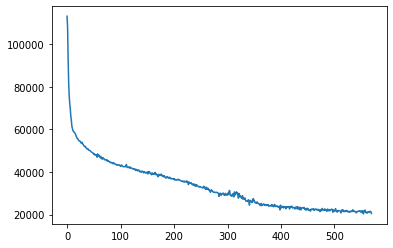

In [81]:
plt.plot(train_loss)
plt.show()

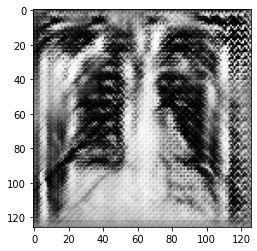

In [84]:
start = torch.randn(1,latent_size)
with torch.no_grad():
  z = torch.FloatTensor(start)
  z = z.reshape((-1, latent_size))
  z = z.to(device)
  z = vae4.fc(z)
  generated_images = vae4.decoder(z)
  generated_images = generated_images.view(-1, image_size, image_size)
  img = generated_images[0].cpu()
  img = img / 2 + 0.5
  plt.imshow(img, cmap='gray')

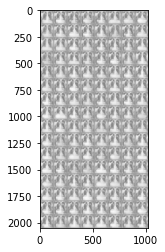

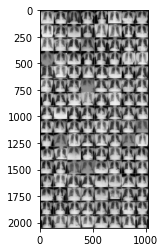

In [85]:
vae4.eval()
vectors = []
with torch.no_grad():
  for i, images in enumerate(testloader):
    images = images.to(device)
    reconstructed_image, mean, log_var = vae4(images)
    reconstructed_image = reconstructed_image.view(-1, 1, image_size, image_size)
    temp = list(mean.tolist())
    for x in temp:
      vectors.append(x)
    if(i%100 == 0):
      show_images(reconstructed_image.cpu())
      #img_name = images_dir + "evaluation/DCVAE/" + str(i).zfill(3)
      # img_name = images_dir + "evaluation/VAE/" + str(i).zfill(3)
      #plt.savefig(img_name)
      plt.show()
      show_images(images.cpu())
      plt.show()

In [ ]:
torch.save(vae4.state_dict(), ruta + '/vae4_rmse_k10000_b64_lr5e-4.pth')

In [ ]:
# Cargamos modelo entrenado
vae4.load_state_dict(torch.load(ruta + '/vae4_rmse_k10000_b64_lr5e-4.pth'))

RuntimeError: ignored

In [ ]:
vae.eval()
start = np.array([-1.8611,  0.3629, -0.1625,  0.6801,  1.2033,  1.0312,  0.5436,  1.3066,
         0.2905,  0.1377,  0.5122, -0.1663,  2.3431, -0.0896, -0.5873, -1.4804,
         0.8141, -1.2197,  0.0484,  0.6414, -0.8172, -0.9543, -0.8818, -1.1465,
         0.2720,  1.1792,  1.8410, -0.4715,  1.4380,  0.5139,  1.2099, -0.5012])
middle = np.array([-0.4763, -0.4644, -0.3850,  0.6598,  0.9110,  0.4451,  0.4617, -0.0526,
         0.2808,  0.6080,  0.5532, -1.5506, -0.5199,  0.1359,  0.0373,  0.4284,
        -0.4134, -1.7078, -0.0309, -1.0195, -0.3151, -0.5569,  0.2832, -0.9132,
        -1.1339, -1.3196,  2.1297,  0.8122,  0.6849, -0.6710, -0.3507, -0.9001])
end = np.array([-1.6239,  0.2496, -1.0690, -0.8745,  0.4133,  2.2452, -0.2385, -0.6532,
         0.3818, -0.9425,  0.9404,  1.3901, -0.3327, -0.3719, -0.0365,  0.3240,
         0.4928, -0.4988, -1.2228, -0.1638,  0.6093, -0.5264, -1.6963, -0.3718,
         2.1971,  0.2166, -0.0821, -0.1722, -0.1896, -1.6610, -0.1497,  1.0655])
#points = 50
#linfit = interpolate.interp1d([1, points/2, points], np.vstack([start, middle, end]), axis=0)
with torch.no_grad():
  for i in range(3):
    z = linfit(i)
    z = torch.FloatTensor(z)
    print(z.shape)
    z = z.reshape((-1, 32))
    z = z.to(device)
    z = vae.fc(z)
    generated_images = vae.decoder(z)
    generated_images = generated_images.view(-1, 64, 64)
    img = generated_images[0].cpu()
    plt.imshow(img)
    img_name = images_dir + 'interpolate/' + str(i).zfill(3)
    plt.savefig(img_name)
    plt.show()

NameError: ignored

# Vamos a probar las DCGAN


In [86]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [87]:
# Root directory for dataset
#dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [88]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [89]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [90]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [91]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [92]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [93]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [96]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


RuntimeError: ignored

In [ ]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var


In [ ]:
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 2
batch_size = 16
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [ ]:
from tqdm import tqdm
import torch 
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

In [ ]:
len(rsna_dataset)

7214

In [ ]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, rsna_dataset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, trainloader, rsna_dataset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch 1 of 2


  0%|          | 0/450 [00:05<?, ?it/s]


RuntimeError: ignored

In [ ]:
#Loss function
criterion = nn.MSELoss() # BinaryCrossEntropy

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS=2
train_loss = []
model.train()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in trainloader:
        img = data # no need for the labels
        print(img.shape)
        img = img.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*img.size(0)
        
    loss = running_loss / len(trainloader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, NUM_EPOCHS, loss))

torch.Size([16, 1, 128, 128])


RuntimeError: ignored

In [ ]:
trainloader

In [ ]:
dataiter = iter(trainloader)
dataiter.next().shape

torch.Size([32, 1, 128, 128])

In [ ]:
z = torch.randn(1, 20).to(device)
# run only the decoder
reconstructed_img = model.dec(z)
#reconstructed_img = reconstructed_img.cpu().numpy()

#output = model(images)
#images = images.cpu().numpy()
img = reconstructed_img.view(224, 224).data
img = img.cpu().detach().numpy()
#img = reconstructed_img .view(batch_size, 3, 32, 32)
#img = img.cpu().detach().numpy()

#output = output.view(batch_size, 3, 32, 32)
#output = output.cpu().detach().numpy()
#img = reconstructed_img.view(224, 224).data
print(z.shape)
print(img.shape)
plt.imshow(img,cmap='gray')

In [ ]:
# Fixed input for debugging
fixed_x, _ = next(iter(trainloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

ValueError: ignored

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


In [ ]:

model = VAE(image_channels=image_channels).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [ ]:

epochs = 2

In [ ]:
for epoch in range(epochs):
    for idx, images in enumerate(trainloader):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        print(to_print)

# notify to android when finished training
notify(to_print, priority=1)

torch.save(vae.state_dict(), 'vae.torch')

RuntimeError: ignored